In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, numpy, string, keras
import xgboost, textblob
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [ ]:
import csv

labels = []
texts = []

with open('input_data/annotated.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        texts.append(row[0])
        labels.append(row[1])      

print(labels)
print(texts)

trainDF = pandas.DataFrame()
trainDF['text'] = texts
trainDF['label'] = labels

In [109]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'].values, trainDF['label'].values)

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [110]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [111]:
xtrain_count
xvalid_count

<197x3614 sparse matrix of type '<class 'numpy.int64'>'
	with 2686 stored elements in Compressed Sparse Row format>

In [112]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [113]:
embeddings_index = {}
for i, line in enumerate(open('data/wiki-news-300d-1M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [114]:
trainDF['char_count'] = trainDF['text'].apply(len)
trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)
trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [115]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shawo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shawo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [116]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

trainDF['noun_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'noun'))
trainDF['verb_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'verb'))
trainDF['adj_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adj'))
trainDF['adv_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adv'))
trainDF['pron_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [117]:
trainDF.head(10)

,text,label,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,3thingsdaily I m grateful for full moon sprin...,Believer,109,13,7.785714,0,1,1,4,3,2,1,1
1,633chiropractic 633chiro blessed complementar...,Believer,95,7,11.875000,0,0,0,3,1,2,0,0
2,Abhyangam is not just a massage but a mode of...,Believer,89,17,4.944444,0,2,0,6,1,1,3,0
3,Absolutely Just the way the Ancient sages des...,Believer,61,9,6.100000,0,4,0,5,1,0,1,0
4,AlternIntegrMed Proof of Evidence for Homeopa...,Believer,90,9,9.000000,0,5,0,7,0,0,0,0
5,Ashwagandha is a powerful herb used in ancien...,Believer,115,19,5.750000,0,3,0,7,3,2,0,0
6,Ayurveda and Traditional Chinese Medicine hav...,Believer,105,15,6.562500,0,4,0,7,3,1,0,1
7,Ayurveda Ayurvedic healthyfood homeremedies h...,Believer,83,7,10.375000,0,3,0,6,1,0,0,0
8,Ayurveda for jetlag daily wellbeing,Believer,37,5,6.166667,0,1,0,2,0,2,0,0
9,Ayurveda for Skincare Follow a Holistic Appro...,Believer,66,10,6.000000,0,7,0,7,0,0,0,0


In [118]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [119]:
def ttrain_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.confusion_matrix(predictions, valid_y)

In [120]:
# Naive Bayes on Count Vectors
accuracy1 = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy3)

# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy4)


NB, Count Vectors:  0.583756345177665
NB, WordLevel TF-IDF:  0.5939086294416244
NB, N-Gram Vectors:  0.6446700507614214
NB, CharLevel Vectors:  0.5786802030456852


[[46 10 37]
 [ 1  6  7]
 [17 10 63]]


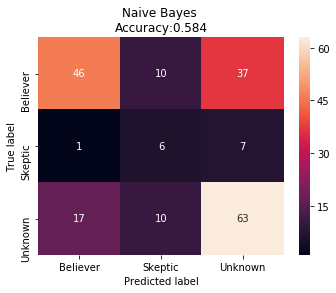

[[23  1 13]
 [ 0  0  0]
 [41 25 94]]


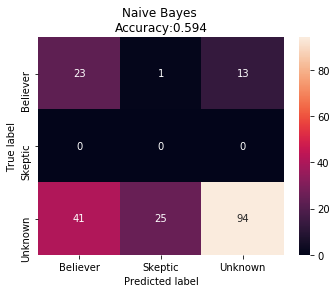

[[25  0  8]
 [ 0  3  0]
 [39 23 99]]


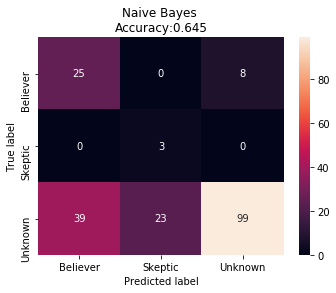

[[ 10   0   3]
 [  0   0   0]
 [ 54  26 104]]


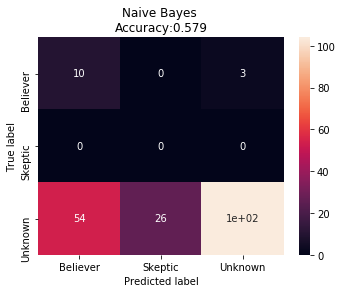

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
# Creates a confusion matrix
cm = ttrain_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy1))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy2))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy3))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy4))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [125]:
# Linear Classifier on Count Vectors
accuracy1 = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy1)

# Linear Classifier on Word Level TF IDF Vectors
accuracy2 = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy2)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3 = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy3)

# Linear Classifier on Character Level TF IDF Vectors
accuracy4 = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy4)

LR, Count Vectors:  0.6446700507614214
LR, WordLevel TF-IDF:  0.6294416243654822
LR, N-Gram Vectors:  0.5939086294416244
LR, CharLevel Vectors:  0.6192893401015228


[[35  5 18]
 [ 0  6  3]
 [29 15 86]]


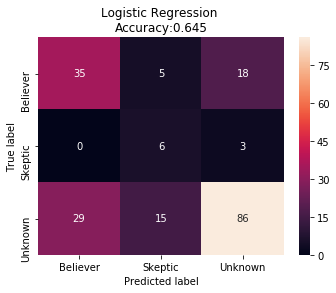

[[23  0  8]
 [ 0  2  0]
 [41 24 99]]


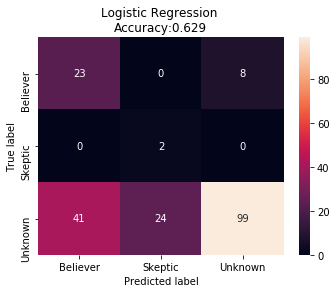

[[ 14   0   4]
 [  0   0   0]
 [ 50  26 103]]


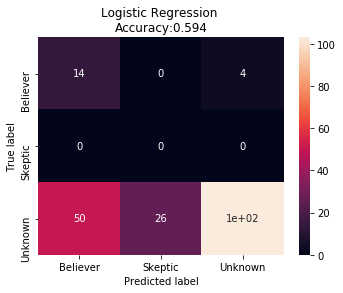

[[24  7  9]
 [ 0  0  0]
 [40 19 98]]


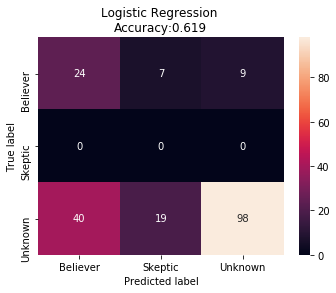

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
# Creates a confusion matrix
cm = ttrain_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy1))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy2))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy3))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy4))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [127]:
# SVM on Ngram Level TF IDF Vectors
accuracy1 = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count)
print("SVM, Count Vectors: ", accuracy1)

accuracy2 = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVM, WordLevel Tf-IDF: ", accuracy2)

accuracy3 = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy3)

accuracy4 = train_model(svm.SVC(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVM, CharLevel Vectors: ", accuracy4)

C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM, Count Vectors:  0.5431472081218274
SVM, WordLevel Tf-IDF:  0.5431472081218274
SVM, N-Gram Vectors:  0.5431472081218274
SVM, CharLevel Vectors:  0.5431472081218274


[[  0   0   0]
 [  0   0   0]
 [ 64  26 107]]


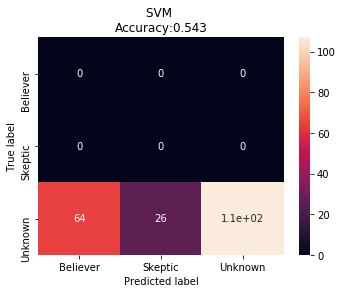

[[  0   0   0]
 [  0   0   0]
 [ 64  26 107]]


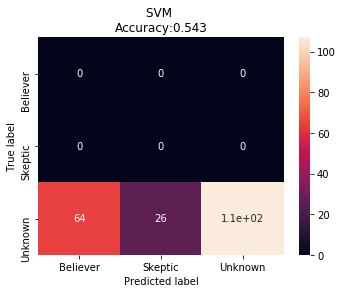

[[  0   0   0]
 [  0   0   0]
 [ 64  26 107]]


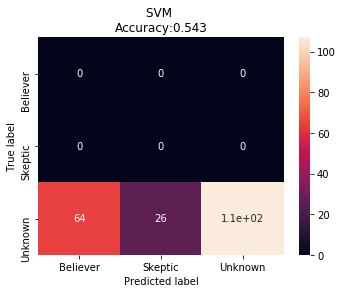

[[  0   0   0]
 [  0   0   0]
 [ 64  26 107]]


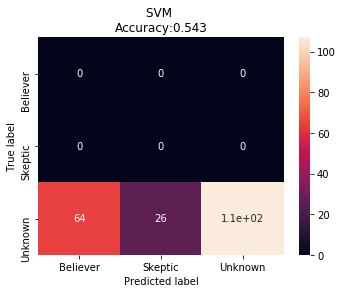

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
# Creates a confusion matrix
cm = ttrain_model(svm.SVC(), xtrain_count, train_y, xvalid_count) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM \nAccuracy:{0:.3f}'.format(accuracy1))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM \nAccuracy:{0:.3f}'.format(accuracy2))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM \nAccuracy:{0:.3f}'.format(accuracy3))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(svm.SVC(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM \nAccuracy:{0:.3f}'.format(accuracy4))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [129]:
# RF on Count Vectors
accuracy1 = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy1)

# RF on Word Level TF IDF Vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy2)

accuracy3 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("RF, N-Gram Vectors: ", accuracy3)

accuracy4 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("RF, CharLevel Vectors: ", accuracy4)

C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors:  0.6345177664974619
RF, WordLevel TF-IDF:  0.6192893401015228


C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, N-Gram Vectors:  0.6192893401015228
RF, CharLevel Vectors:  0.5786802030456852


C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[22  4 20]
 [ 3  5  2]
 [39 17 85]]


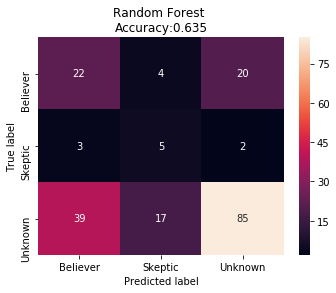

C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[29  8 19]
 [ 1  5  2]
 [34 13 86]]


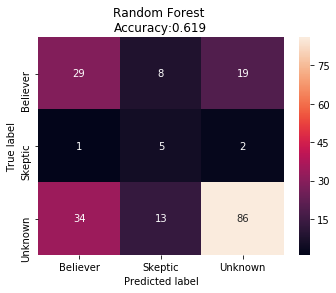

C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 25   2   5]
 [  0   4   2]
 [ 39  20 100]]


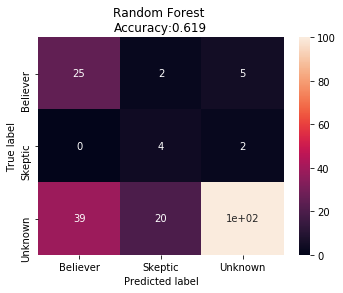

C:\Users\shawo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[37  7 43]
 [ 1  4  2]
 [26 15 62]]


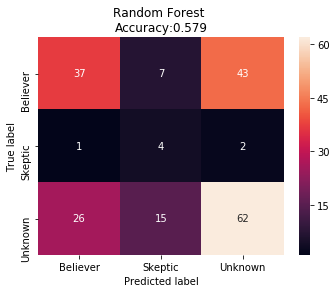

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
# Creates a confusion matrix
cm = ttrain_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy1))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy2))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy3))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Creates a confusion matrix
cm = ttrain_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars) 
print(cm)
# Transform to df for easier plotting
cm_df = pandas.DataFrame(cm,
                     index = ['Believer','Skeptic','Unknown'], 
                     columns = ['Believer','Skeptic','Unknown'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy4))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()